# 텐서플로로 0~5까지 숫자 맞추기

이 예제는 코세라의 Deep Learning AI 강좌 중 Course 2의 과제를 이용하였습니다. 이 데이터는 0~5까지의 숫자를 손으로 나타낸 이미지입니다.

다음은 서버에 필요한 데이터와 유틸리티 파일을 저장하는 방법입니다. 주피터 노트북만 이용하는 경우에는 아래 순서를 따라할 필요가 없습니다.

이미지 데이터는 test_signs.h5(https://goo.gl/RNPd2M), train_signs.h5(https://goo.gl/j8G5ya) 입니다. 그리고 유틸리티 파일인 sign_util.py(https://goo.gl/Vcty2o)를 다운받아야 합니다. test_signs.h5와 train_signs.h5 파일은 현재 주피터 노트북을 실행한 디렉토리 밑에 __datasets__ 폴더를 만들고 그 밑으로 옮깁니다. sign_util.py 파일은 주피터 노트북을 실행한 디렉토리와 동일한 디렉토리에 놓으면 됩니다.

윈도우즈에서 다운로드 받았다면 파일 확장자가 변경되지 않도록 주의해 주세요. 우분투 서버에서 직접 다운로드 받으려면 다음 명령을 사용합니다.

$ wget https://goo.gl/RNPd2M -O test_signs.h5

$ wget https://goo.gl/j8G5ya -O train_signs.h5

$ wget https://goo.gl/Vcty2o -O sign_util.py

데이터가 HDF5 파일로 저장되어 있기 때문에 이 파일을 읽어들이기 위해서는 h5py 패키지를 설치해 주어야 합니다. 텐서플로가 설치된 conda 환경을 활성화했는지 확인한 후에 

$ conda install h5py

명령으로 설치합니다. 필요하다면 주피터 노트북의 커널을 다시 로드합니다.

우리가 풀어야할 문제는 이미지를 읽어서 어떤 숫자인지 인식하는 신경망을 만드는 것입니다. 먼저 텐서플로를 임포트합니다.

In [1]:
import tensorflow as tf

/Users/rickypark/anaconda3/envs/hongdae-ml-study/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


여기서 필요한 패키지가 몇가지 있는데 먼저 데이터 주입을 위한 NumPy와 그래프를 그리기 위한 matplotlib 패키지입니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

데이터 파일을 읽어서 미니 배치를 리턴해 주는 유틸리티 모듈을 로드합니다.

In [3]:
import sign_util

load_dataset() 함수에서 훈련 데이터와 테스트 데이터 그리고 클래스를 읽습니다. 보통 관례적으로 훈련 데이터는 다차원 배열 혹은 행렬이기 때문에 대문자로 표시하고 타깃 데이터는 1차원이기 때문에 소문자로 표시합니다.

In [4]:
X_train, y_train, X_test, y_test, classes = sign_util.load_dataset()

X_train, X_test 크기를 살펴 보겠습니다. 이 객체들은 모두 NumPy 오브젝트 입니다.

In [5]:
X_train.shape, X_test.shape

((1080, 64, 64, 3), (120, 64, 64, 3))

훈련 데이터는 1080개가 있고 테스트 데이터는 120개가 있습니다. 각 이미지는 64x64x3 크기를 가지므로 가로, 세로가 각각 64 픽셀 크기이고 RGB 채널을 가진 컬러 이미지입니다.

타깃과 클래스를 살펴 보겠습니다.

In [6]:
y_train.shape, y_test.shape, classes

((1080,), (120,), array([0, 1, 2, 3, 4, 5]))

타깃 데이터는 모두 1차원 배열임을 알 수 있습니다. 클래스는 0에서 부터 5까지 6개입니다. 샘플로 이미지 몇 개를 그려 보겠습니다.

y = 5


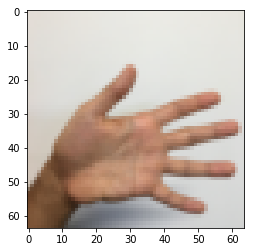

In [7]:
print("y = " + str(np.squeeze(y_train[0])))
plt.imshow(X_train[0]);

y = 0


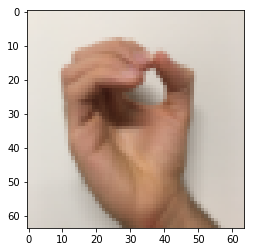

In [8]:
print("y = " + str(np.squeeze(y_train[1])))
plt.imshow(X_train[1]);

신경망에 이미지를 주입하려면 1차원 배열로 늘어 세워야 합니다. 훈련 데이터와 테스트 데이터가 64x64x3 크기이므로 이를 1차원 배열로 만들면 12,288 크기의 배열이 됩니다.

즉 입력층의 크기는 12,288입니다.

그런데 첫 번째 차원은 훈련 샘플의 개수이므로 첫 번째 차원은 고정하고 나머지 차원을 일렬로 늘입니다. NumPy의 reshape() 메서드는 배열의 차원을 변경하여 줍니다. -1로 지정하면 다른 차원을 먼저 맞추고 남는 차원을 할당한다는 의미입니다.

In [9]:
X_train = X_train.reshape(1080, -1)
X_test = X_test.reshape(120, -1)

In [10]:
X_train.shape, X_test.shape

((1080, 12288), (120, 12288))

첫 번째 이미지의 데이터를 살짝 들여다 보겠습니다.

In [11]:
X_train[0][:100]

array([227, 220, 214, 227, 221, 215, 227, 222, 215, 227, 221, 215, 227,
       222, 215, 228, 223, 216, 228, 223, 216, 228, 223, 217, 229, 224,
       218, 229, 224, 218, 230, 225, 220, 230, 226, 220, 231, 226, 221,
       231, 227, 221, 232, 228, 222, 231, 229, 222, 232, 229, 222, 231,
       229, 222, 232, 230, 223, 232, 230, 224, 232, 230, 225, 233, 231,
       225, 232, 231, 225, 232, 231, 226, 233, 232, 226, 232, 232, 227,
       233, 232, 227, 233, 232, 227, 233, 232, 227, 234, 233, 228, 234,
       233, 229, 234, 234, 229, 235, 234, 229, 235], dtype=uint8)

원래 훈련 데이터는 1080x64x64x3 크기 였는데 1080x12288로 변경되었습니다. 마찬가지로 테스트 데이터도 120x12288로 변경되었습니다.

이미지의 픽셀은 0~255 사이의 값을 가집니다. 신경망은 특성이 정규화되어 있어야 좋은 성능을 발휘합니다. 보통 이미지의 경우는 0~1 사이로 변환합니다. 따라서 훈련 데이터와 테스트 데이터를 255로 나누어 0~1 사이로 만듭니다.

In [12]:
X_train = X_train/255.
X_test = X_test/255.

훈련 데이터의 크기에는 변화가 없습니다. 첫 번째 이미지의 데이터가 0~1 사이로 변환이 잘 되었는지 확인해 보겠습니다.

In [13]:
X_train.shape, X_test.shape

((1080, 12288), (120, 12288))

In [14]:
X_train[0][:100]

array([0.89019608, 0.8627451 , 0.83921569, 0.89019608, 0.86666667,
       0.84313725, 0.89019608, 0.87058824, 0.84313725, 0.89019608,
       0.86666667, 0.84313725, 0.89019608, 0.87058824, 0.84313725,
       0.89411765, 0.8745098 , 0.84705882, 0.89411765, 0.8745098 ,
       0.84705882, 0.89411765, 0.8745098 , 0.85098039, 0.89803922,
       0.87843137, 0.85490196, 0.89803922, 0.87843137, 0.85490196,
       0.90196078, 0.88235294, 0.8627451 , 0.90196078, 0.88627451,
       0.8627451 , 0.90588235, 0.88627451, 0.86666667, 0.90588235,
       0.89019608, 0.86666667, 0.90980392, 0.89411765, 0.87058824,
       0.90588235, 0.89803922, 0.87058824, 0.90980392, 0.89803922,
       0.87058824, 0.90588235, 0.89803922, 0.87058824, 0.90980392,
       0.90196078, 0.8745098 , 0.90980392, 0.90196078, 0.87843137,
       0.90980392, 0.90196078, 0.88235294, 0.91372549, 0.90588235,
       0.88235294, 0.90980392, 0.90588235, 0.88235294, 0.90980392,
       0.90588235, 0.88627451, 0.91372549, 0.90980392, 0.88627

훈련 데이터 1,080개를 한꺼번에 모두 주입하는 것은 메모리가 부족할 수 있으니 미니 배치로 32개씩 나누어 훈련시키려고 합니다. 따라서 훈련 데이터와 타깃에 대응하는 플레이스홀더를 준비합니다.

In [15]:
X = tf.placeholder(tf.float32, shape=(None, 12288))
y = tf.placeholder(tf.int32, shape=(None))

여기서는 텐서플로의 고수준 함수를 사용하려 완전 연결 레이어를 만들도록 하겠습니다. tf.layer.dense() 함수는 은닉층의 개수를 전달하면 자동으로 가중치와 편향을 만들어 주기 때문에 일일이 변수 선언을 하지 않아도 되므로 편리합니다.

입력층은 12288개이고 첫 번째 은닉층은 25개로 만들겠습니다(이 값에 어떤 의미가 있는 것은 아니고 코세라 강좌를 따른 것입니다). 그리고 활성화 함수는 렐루 함수를 사용하겠습니다. 렐루는 음수는 버리고 양수만 다음 레이어로 전달합니다.

In [16]:
h1 = tf.layers.dense(X, 25, activation=tf.nn.relu)
h1

<tf.Tensor 'dense/Relu:0' shape=(?, 25) dtype=float32>

이전과 마찬가지로 dense() 함수의 반환값은 역시 텐서입니다. 이 텐서가 가리키는 연산은 Relu 임을 알 수 있습니다. 물론 Relu 뒤에 연결된 여러 연산이 이어져 있을 것입니다. dense() 함수를 쓰면 여러 행렬 연산을 대신 처리하므로 코드가 깔끔해 집니다.

이어서 12개의 히든 유닛을 가진 은닉층과 마지막에 6개의 유닛을 가진 출력층을 만들겠습니다. 출력층의 유닛이 6개인 것은 이 분류 문제가 6개의 클래스를 가지고 있기 때문에 각각 6개에 대한 확률을 출력하기 위해서 입니다. 출력층에는 활성화 함수를 적용하지 않습니다. 보통 출력층의 값을 로짓(logits) 또는 $\hat{y}$(y_hat)이라고 부릅니다.

In [17]:
h2 = tf.layers.dense(h1, 12, activation=tf.nn.relu)
logits = tf.layers.dense(h2, 6)

분류 문제에서 대표적으로 사용하는 것이 크로스 엔트로피 손실 함수입니다. 텐서플로에는 로짓과 타깃값을 매개변수로 전달하면 자동으로 크로스 엔트로피 손실 함수를 계산해 주는 함수가 있습니다.

tf.nn.softmax_cross_entropy_with_logits(labels=.., logits=..) 이 함수는 타깃(label)이 원 핫 인코딩(one_hot_encoding) 되어 있을 때 사용합니다.

tf.nn.sparse_softmax_cross_entropy_with_logits(labels=.., logits=..) 이 함수는 타깃(lable)이 1차원 배열일 때 사용할 수 있습니다. 여기서는 y_train이 1차원 배열이므로 이 함수를 사용하겠습니다.

그리고 미니 배치로 훈련을 하게되므로 계산된 크로스 엔트로피 손실이 미니 배치 개수만큼 반환됩니다. 낱개의 손실 값을 확인하는 것은 큰 의미가 없으므로 미니 배치 전체에 대한 평균값을 계산하겠습니다. tf.reduce_mean()은 입력 텐서의 값을 평균내는 함수입니다. 

In [18]:
entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
cost = tf.reduce_mean(entropy)

텐서플로에서 제공하는 경사 하강법 옵티마이저는 대표적으로 tf.train.GradientDescentOptimizer, tf.train.AdamOptimizer, tf.train.RMSPropOptimizer 등이 있습니다. 여기서는 일반적으로 GradientDescentOptimizer를 사용하겠습니다. 옵티마이저 객체를 만들고 나면 minimize() 메서드를 호출해 훈련 연산을 만들어야 합니다. 이 때 최적화하고자 하는 연산을 넣어 주어야 합니다. 여기서는 바로 cost가 됩니다. 즉 미니 배치의 크로스 엔트로피 평균을 최소화합니다.

학습률은 0.001로 진행합니다.

In [19]:
optimizer = tf.train.GradientDescentOptimizer(0.001)
training_op = optimizer.minimize(cost)

이제 거의 구성 단계가 끝나 갑니다. 마지막으로 훈련과 테스트 과정에서 얼마나 예측이 정확했는지를 알기 위해 정확도를 계산하는 연산을 만듭니다.

tf.nn.in_top_k(prediction, targets, k) 함수는 prediction 배열에서 상위 k번째 안에 targets이 들어 있는지 여부를 체크합니다. 따라서 다음과 같이 작성하면 logits에서 가장 높은 값의 클래스가 y인지를 확인합니다. 그리고 참/거짓을 반환합니다.

tf.cast() 함수는 in_top_k() 에서 반환받은 불리언 값을 실수로 변환한 다음 역시 미니 배치에 대해 평균을 냅니다. 이 값이 전체 미니 배치 개수에서 몇 개가 정확히 맞았는지를 나타내는 평균값이 됩니다.

In [20]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

그 다음은 이전과 마찬가지로 모든 변수를 (비록 여기서는 dense() 함수를 사용하여 명시적으로 만들지는 않았지만) 초기화해주는 연산을 만들고 세션을 열어 변수를 초기화합니다.

In [21]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

1,080개의 이미지를 여러번 반복하여 훈련에 사용할 것입니다. 전체 횟수를 num_epochs에 저장합니다. epoch 반복이 될 때마다 NumPy 랜덤 함수의 시드 값을  바꾸어 줍니다. 이는 반복될 때 마다 이미지의 순서를 뒤섞게 하기 위해서 입니다.

미니 배치를 훈련할 때마다 얻어진 비용 값을 파이썬 리스트에 저장합니다. 이는 나중에 훈련이 잘 되었는지 그래프를 그려보기 위해서입니다.

훈련에 사용할 미니 배치의 크기를 정합니다. 그리고 몇 개의 미니 배치가 만들어지는지 개수를 계산합니다.

In [22]:
seed = 0
num_epochs = 1000
costs = []
minibatch_size = 32
num_minibatches = int(X_train.shape[0] / minibatch_size)
num_minibatches

33

미니 배치의 개수는 총 34개가 되며 마지막 미니 배치는 $1080-33\times32 = 24$개의 샘플만 담고 있습니다.

random_mini_batches() 함수는 훈련 미니 배치와 타깃 미니 배치 34개를 담은 리스트를 반환합니다.

In [23]:
for epoch in range(num_epochs):
    
    epoch_cost = 0. # 미니 배치의 비용 값을 누적합니다.
    seed = seed + 1
    
    # random_mini_batches() 함수는 샘플 데이터에서 미니 배치를 만들어 줍니다.
    minibatches = sign_util.random_mini_batches(X_train, y_train, minibatch_size, seed)

    # minicatches는 [34][2] 크기를 가집니다.
    for minibatch in minibatches:

        # 미니 배치에서 훈련 데이터와 타깃을 꺼냅니다.
        (minibatch_X, minibatch_y) = minibatch

        # training_op은 훈련 연산이므로 별도로 반환하는 값이 없어 그냥 버립니다.
        _ , minibatch_cost = sess.run([training_op, cost], feed_dict={X: minibatch_X, y: minibatch_y})

        # 미니 배치 비용 값은 배치 개수에 대한 평균값을 계산하여 저장합니다.
        epoch_cost += minibatch_cost / num_minibatches

    # 100번의 에포크 마다 비용값을 출력해 봅니다.
    if epoch % 100 == 0:
        acc = sess.run(accuracy, feed_dict={X: X_train, y: y_train})
        print ("에포크 %i: %f %f" % (epoch, epoch_cost, acc))

    # 그래프를 그리기 위해 5번 에포크 마다 비용을 저장합니다.
    if epoch % 5 == 0:
        costs.append(epoch_cost)

에포크 비용 0: 1.861595 0.196296
에포크 비용 100: 1.286288 0.478704
에포크 비용 200: 0.760677 0.769444
에포크 비용 300: 0.520838 0.854630
에포크 비용 400: 0.386627 0.891667
에포크 비용 500: 0.266243 0.928704
에포크 비용 600: 0.174742 0.926852
에포크 비용 700: 0.137040 0.982407
에포크 비용 800: 0.090734 0.984259
에포크 비용 900: 0.069381 0.989815


비용 값이 에포크가 진행됨에 따라 어떻게 변화되었는지 그래프로 그려 봅니다.

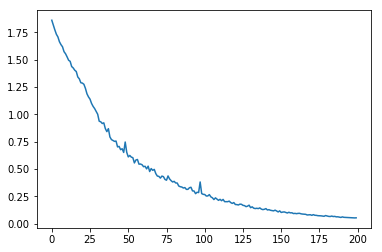

In [24]:
plt.plot(costs);

최종적으로 테스트 세트의 정확도를 계산합니다.

In [25]:
sess.run(accuracy, feed_dict={X: X_test, y: y_test})

0.84166664

In [26]:
y_hat = sess.run(logits, feed_dict={X: X_test, y: y_test})

In [27]:
np.sum(np.argmax(y_hat, axis=1) == y_test)

101